# KMeans Clustering Analysis

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt



spark = SparkSession.builder \
    .appName("JobPostingsAnalysis") \
    .getOrCreate()

file_path = "data/lightcast_job_postings.csv"

df_c = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("escape", "\"") \
    .csv(file_path)
#df_c.show(5)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/10/11 10:51:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark.sql.functions import regexp_replace, trim, col, split, explode

df_clean = df_c.withColumn(
    "SPECIALIZED_SKILLS_NAME",
    regexp_replace(col("SPECIALIZED_SKILLS_NAME"), r"[\[\]\n\"]", "")
)


In [3]:
import numpy as np
from pyspark.sql.functions import expr, col, when

# Calculate overall median salary
overall_median_salary = df_clean.approxQuantile("SALARY", [0.5], 0.01)[0]

# Median by employment type
median_by_employment_type = df_clean.groupBy("EMPLOYMENT_TYPE") \
    .agg(expr("percentile_approx(SALARY, 0.5)").alias("median_salary_emp_type"))

# Median by employment type name
median_by_employment_type_name = df_clean.groupBy("EMPLOYMENT_TYPE_NAME") \
    .agg(expr("percentile_approx(SALARY, 0.5)").alias("median_salary_emp_type_name"))

# Join and fill missing salaries
df_clean = df_clean.join(
    median_by_employment_type_name,
    on="EMPLOYMENT_TYPE_NAME",
    how="left"
).withColumn(
    "SALARY",
    when(col("SALARY").isNotNull(), col("SALARY"))
    .when(col("median_salary_emp_type_name").isNotNull(), col("median_salary_emp_type_name"))
    .otherwise(overall_median_salary)
).drop("median_salary_emp_type_name")
df_selected = df_clean.select("SALARY", "NAICS_2022_2_NAME", "SPECIALIZED_SKILLS_NAME")
df_selected.dropna()


DataFrame[SALARY: double, NAICS_2022_2_NAME: string, SPECIALIZED_SKILLS_NAME: string]

In [4]:
from pyspark.sql.functions import when, lower, sum, avg, col, split, trim, lower, size, array_intersect, array
from pyspark.sql.types import IntegerType


ai_skills = ["machine learning", "artificial intelligence", "deep learning", "data science", "neural networks", "computer vision", "natural language processing", "nlp", "ai", "predictive analytics", "data mining", "tensorflow", "pytorch", "data engineering", "big data" ]

# Create a column as an array of skills
df_array = df_selected.withColumn(
    "skills_array",
    split(lower(col("SPECIALIZED_SKILLS_NAME")), ",")
)

# Trim whitespace from array elements
from pyspark.sql.functions import expr
df_array = df_array.withColumn(
    "skills_array",
    expr("transform(skills_array, x -> trim(x))")
)

# Define AI skills as a Spark array
ai_skills_spark = array(*[expr(f"'{s}'") for s in ai_skills])

# Count AI skills using array_intersect
df_features = df_array.withColumn(
    "AI_skill_count",
    size(array_intersect(col("skills_array"), ai_skills_spark))
)

df_industry = df_features.groupBy("NAICS_2022_2_NAME").agg(
    avg("AI_skill_count").alias("avg_ai_skills"),
    expr("percentile_approx(SALARY, 0.5)").alias("median_salary")
)
df_industry = df_industry.dropna(subset=["NAICS_2022_2_NAME"])
df_industry.orderBy(col("avg_ai_skills").desc()).show(10, truncate=False)


+---------------------------------------------+-------------------+-------------+
|NAICS_2022_2_NAME                            |avg_ai_skills      |median_salary|
+---------------------------------------------+-------------------+-------------+
|Real Estate and Rental and Leasing           |0.581032412965186  |116500.0     |
|Transportation and Warehousing               |0.556910569105691  |116500.0     |
|Manufacturing                                |0.5415371866583799 |116500.0     |
|Information                                  |0.5210486513738342 |116500.0     |
|Management of Companies and Enterprises      |0.4833948339483395 |116500.0     |
|Finance and Insurance                        |0.4584581857804413 |116500.0     |
|Mining, Quarrying, and Oil and Gas Extraction|0.4583333333333333 |116500.0     |
|Retail Trade                                 |0.3911930363543267 |116500.0     |
|Health Care and Social Assistance            |0.3667014250955857 |116500.0     |
|Utilities      

In [5]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Index industry
indexer = StringIndexer(inputCol="NAICS_2022_2_NAME", outputCol="industry_idx")
df_indexed = indexer.fit(df_industry).transform(df_industry)

# One-hot encode
encoder = OneHotEncoder(inputCol="industry_idx", outputCol="industry_vec")
df_encoded = encoder.fit(df_indexed).transform(df_indexed)

# Assemble features
assembler = VectorAssembler(
    inputCols=["avg_ai_skills", "median_salary", "industry_vec"],
    outputCol="features"
)
df_features_final = assembler.transform(df_encoded)
df_features_final.select("features").show(5, truncate=False)



+------------------------------------------------+
|features                                        |
+------------------------------------------------+
|(22,[0,1,3],[0.20155308298562818,116500.0,1.0]) |
|(22,[0,1,16],[0.28144329896907216,87216.0,1.0]) |
|(22,[0,1,17],[0.581032412965186,116500.0,1.0])  |
|(22,[0,1,10],[0.5210486513738342,116500.0,1.0]) |
|(22,[0,1,20],[0.24957841483979765,116500.0,1.0])|
+------------------------------------------------+
only showing top 5 rows



In [6]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# 1. Initialize KMeans
kmeans = KMeans(featuresCol="features", k=5, seed=42)  # choose k as desired

# 2. Fit model
model = kmeans.fit(df_features_final)

# 3. Make predictions
predictions = model.transform(df_features_final)

# 4. Evaluate clustering (optional)
evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette")
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette score: {silhouette}")

# 5. Inspect cluster centers
centers = model.clusterCenters()
print("Cluster Centers:")
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")

# 6. Show cluster assignments
predictions.select("NAICS_2022_2_NAME", "avg_ai_skills", "median_salary", "prediction").show(10, truncate=False)

Silhouette score: 0.8571427459116544
Cluster Centers:
Cluster 0: [3.75421086e-01 1.16500000e+05 5.55555556e-02 5.55555556e-02
 5.55555556e-02 0.00000000e+00 5.55555556e-02 0.00000000e+00
 5.55555556e-02 5.55555556e-02 5.55555556e-02 5.55555556e-02
 5.55555556e-02 5.55555556e-02 5.55555556e-02 5.55555556e-02
 0.00000000e+00 5.55555556e-02 5.55555556e-02 5.55555556e-02
 5.55555556e-02 5.55555556e-02]
Cluster 1: [2.81443299e-01 8.72160000e+04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
Cluster 2: [3.54790419e-01 1.07500000e+05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000

+------------------------------------------------------------------------+-------------------+-------------+----------+
|NAICS_2022_2_NAME                                                       |avg_ai_skills      |median_salary|prediction|
+------------------------------------------------------------------------+-------------------+-------------+----------+
|Administrative and Support and Waste Management and Remediation Services|0.20155308298562818|116500.0     |0         |
|Public Administration                                                   |0.28144329896907216|87216.0      |1         |
|Real Estate and Rental and Leasing                                      |0.581032412965186  |116500.0     |0         |
|Information                                                             |0.5210486513738342 |116500.0     |0         |
|Unclassified Industry                                                   |0.24957841483979765|116500.0     |0         |
|Accommodation and Food Services        

In [7]:
from pyspark.sql.functions import avg, count

cluster_summary = predictions.groupBy("prediction", "NAICS_2022_2_NAME").agg(
    avg("avg_ai_skills").alias("avg_ai_skills"),
    avg("median_salary").alias("median_salary"),
    count("*").alias("num_postings")
).orderBy("prediction")

#cluster_summary.show(20, truncate=False)


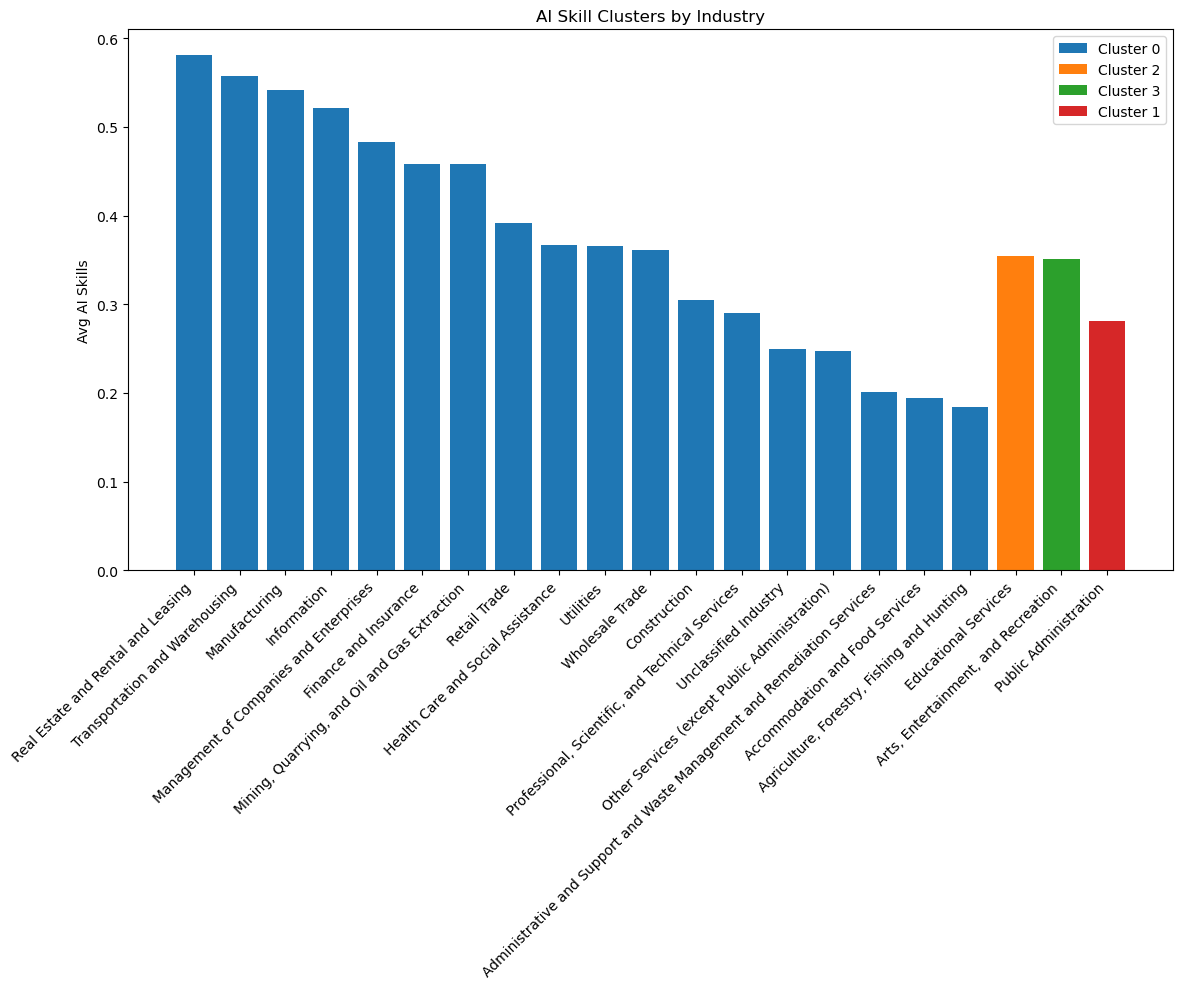

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to pandas
cluster_pd = cluster_summary.toPandas()

# Sort by avg_ai_skills
cluster_pd = cluster_pd.sort_values("avg_ai_skills", ascending=False)

plt.figure(figsize=(12,10))
for cluster in cluster_pd['prediction'].unique():
    subset = cluster_pd[cluster_pd['prediction'] == cluster]
    plt.bar(subset['NAICS_2022_2_NAME'], subset['avg_ai_skills'], label=f"Cluster {cluster}")

# Rotate x-axis labels 45 degrees and align right
plt.xticks(rotation=45, ha='right')
plt.ylabel("Avg AI Skills")
plt.title("AI Skill Clusters by Industry")
plt.legend()
plt.tight_layout()  # Ensure labels fit nicely
plt.savefig("ai_skill_clusters.png", dpi=300, bbox_inches='tight')
plt.show()



# Interpretation

Most industries ended up in Cluster 0, which seems to represent a baseline group with a very average AI skill level, the highest being around 0.6.  This model looked to detect the presence of AI skills amongst other skills listed, so we could consider this moderate AI skill demand in job postings. The other clusters (Clusters 1–3) each only have one industry, and their average AI skill levels are closer to 0.3, meaning they’re significantly less AI focused. This KMeans analysis found that most industries share a similar level of AI skill demand in job postings, while a few have much lower AI significance.  These industries being Arts, Education, and Public Administration are not surprising. The Arts industries generally reject AI adoption, as it is oppositional to their core purpose.  Education may have some AI adoption, but other skills related to teaching will be much more in demand.  Public Administration can be slow to adopt technologies in general, which could explain the lack of AI keyword presence in these postings.